##### Disclaimers 
This material is derived from **[scikit-learn-mooc](https://github.com/INRIA/scikit-learn-mooc)** under the fair-usage clause of `Creative Commons`.

*References to all the sources apart from the scikit-learn-mooc are linked*

### SEVENTH SESSION

#### Feature Importance

In this section, we will detail methods to investigate the importance of features used by a given model. 

We will look at:

* interpreting the coefficients in a linear model;

* the attribute `feature_importances_` in RandomForest;

* permutation feature importance, an inspection technique that can be used for any fitted model.


We will use the california_housing dataset, which has the following columns. 

* MedInc: median income in block

* HouseAge: median house age in block

* AveRooms: average number of rooms

* AveBedrms: average number of bedrooms

* Population: block population

* AveOccup: average house occupancy

* Latitude: house block latitude

* Longitude: house block longitude

* MedHouseVal: Median house value in 100k$ (target)

To assert the quality of our inspection technique, we will add some random features that won’t help the prediction.

We then plot this data and observe that the median income positively correlates to the median house price (the target).

We will also see that the average number of rooms `AveRooms` correlates to the average number of bedrooms `AveBedrms`.

In [42]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

X, y = fetch_california_housing(
    as_frame=True,
    return_X_y=True
)

In [43]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [44]:
# To speed up the computation, we consider only the first 10000 samples
X = X[:10000]
y = y[:10000]

In [45]:
import numpy as np

# Adding random features
rng = np.random.RandomState(42)

bin_var = pd.Series(
    rng.randint(0, 1, X.shape[0]),
    name='rnd_bin'
)

num_var = pd.Series(
    np.arange(X.shape[0]),
    name='rnd_num'
)

X_with_rnd_feat = pd.concat(
    (X, bin_var, num_var),
    axis=1
)


In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_with_rnd_feat,
    y,
    random_state=42
)


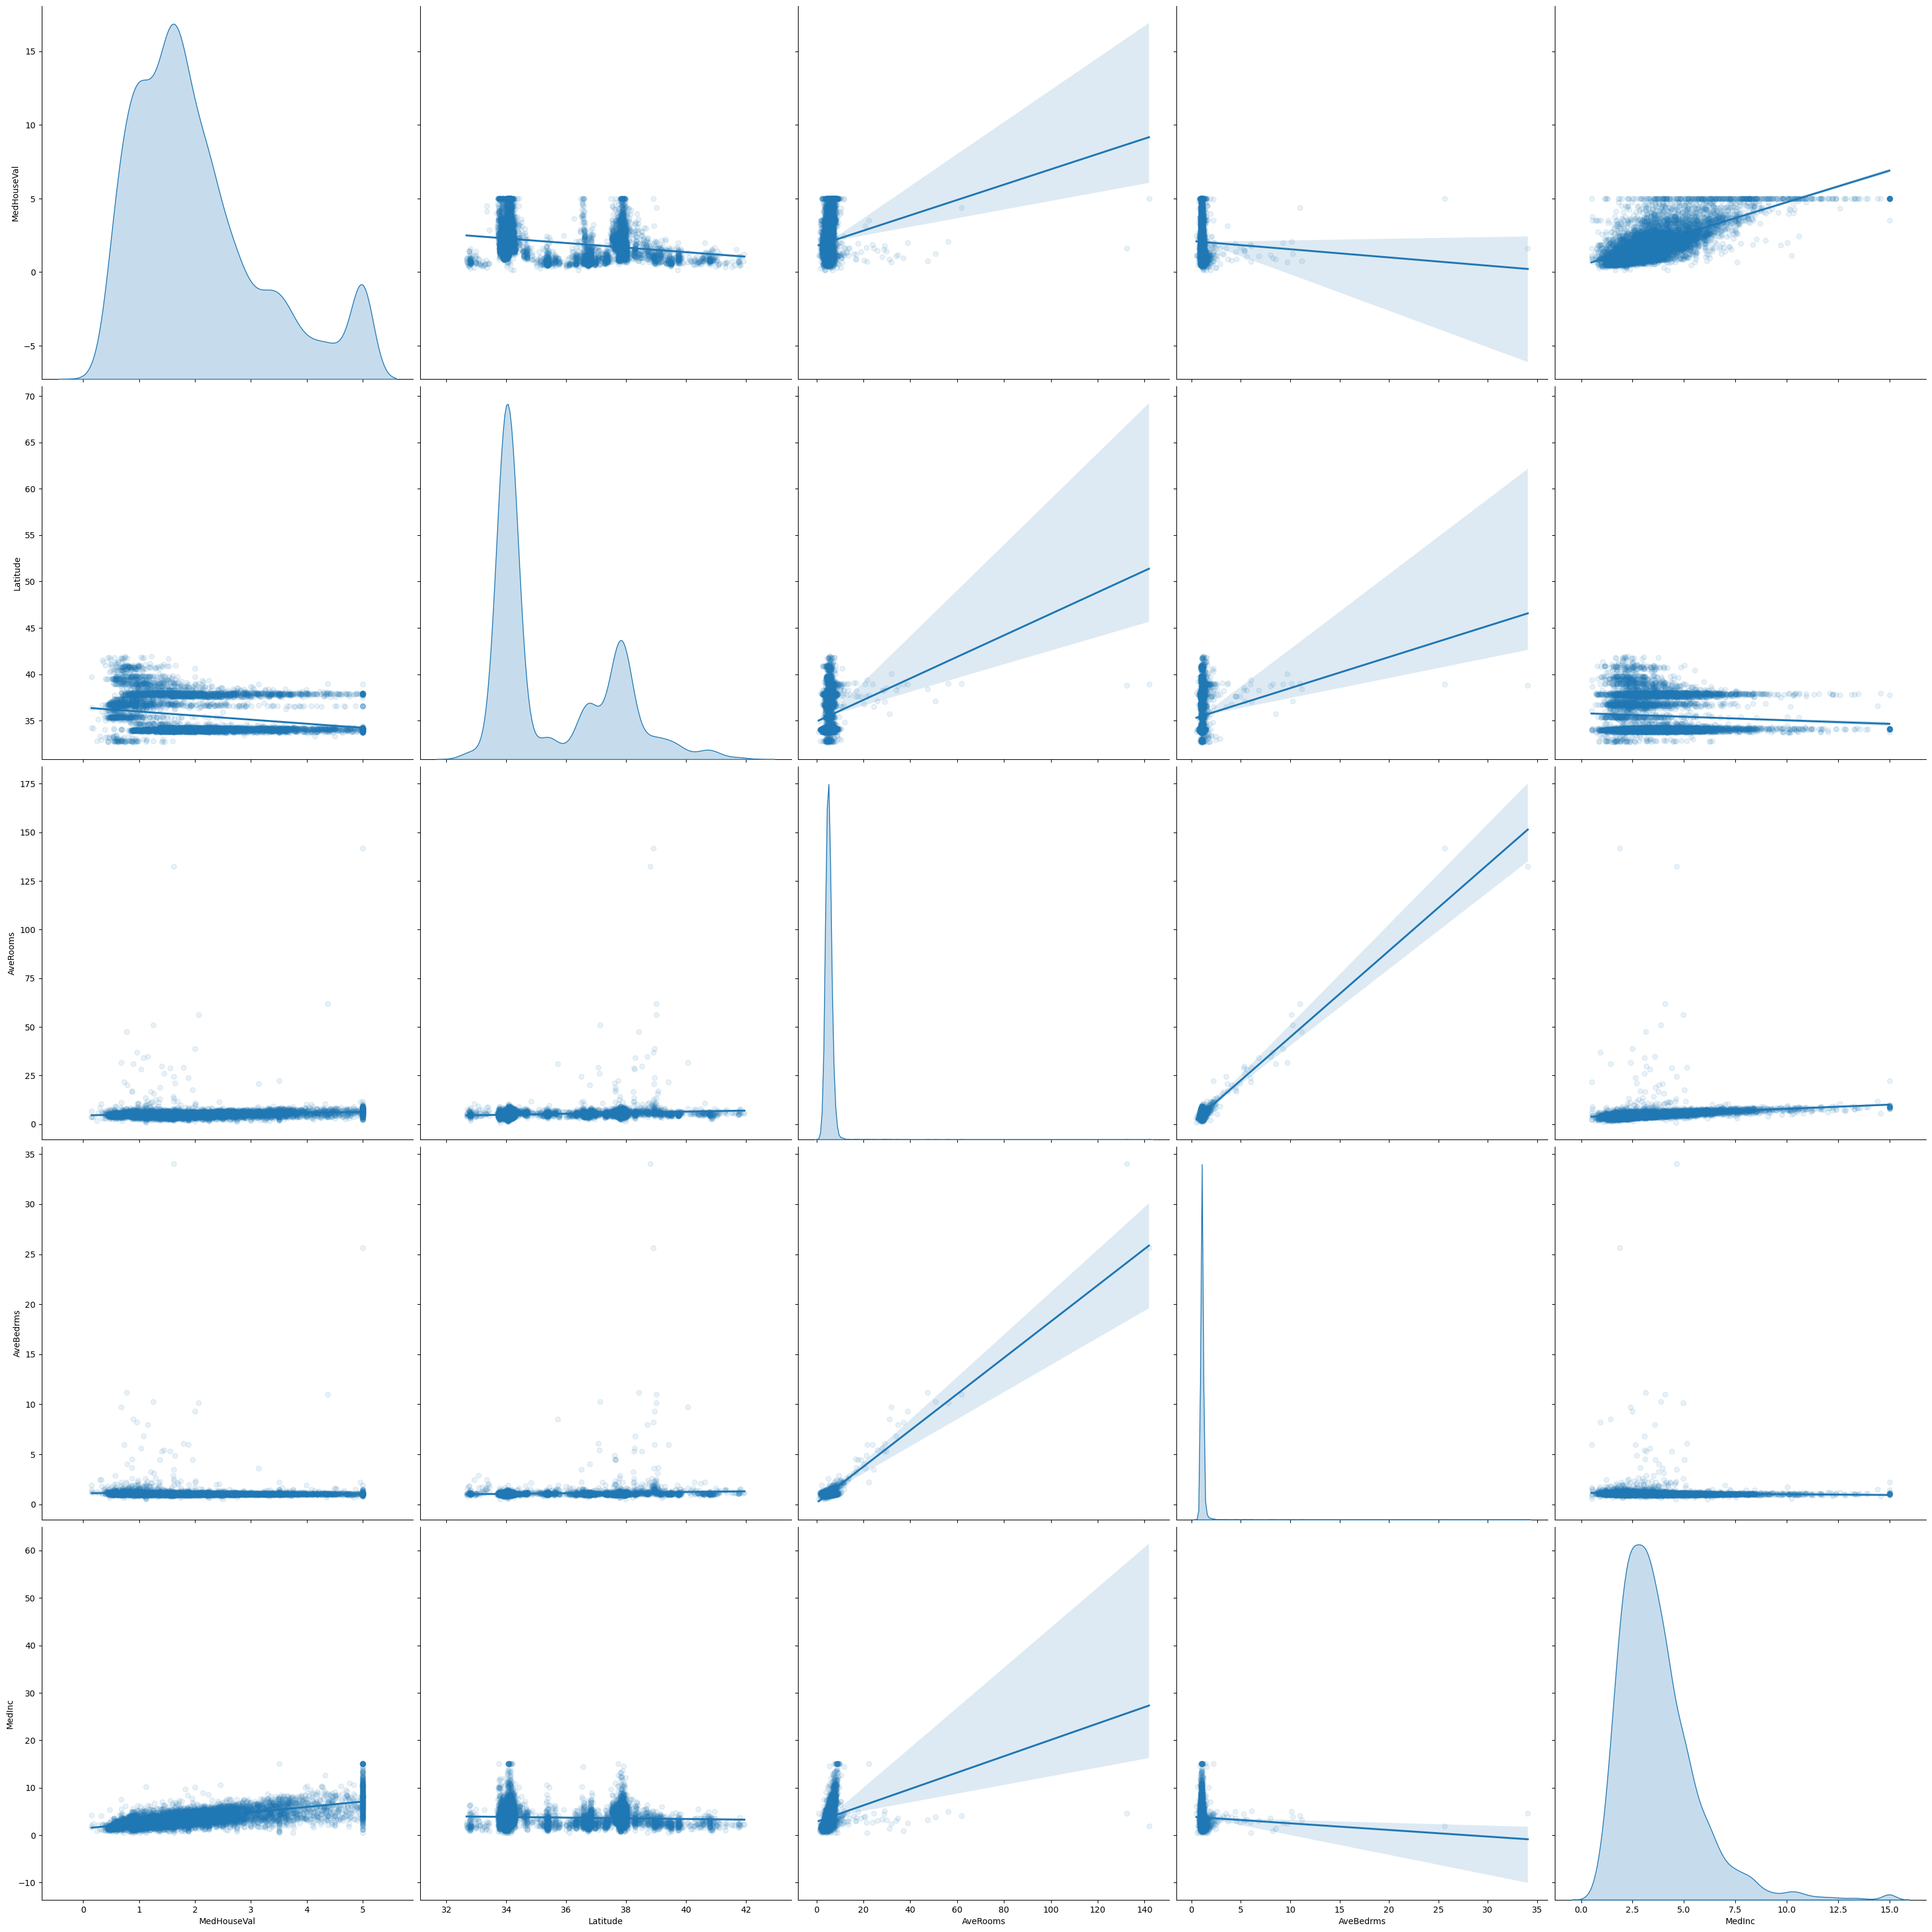

In [47]:
import seaborn as sns

train_dataset = X_train.copy()

train_dataset.insert(0, "MedHouseVal", y_train)

_ = sns.pairplot(
    train_dataset[
        [
            'MedHouseVal',
            'Latitude',
            'AveRooms',
            'AveBedrms',
            'MedInc'
        ]
    ],
    kind='reg',
    diag_kind='kde',
    plot_kws={'scatter_kws': {'alpha': 0.1}},
    height=6.5, aspect=1
)

##### Linear model inspection
The target value is modeled in linear models as a linear combination of the features.

**Coefficients represent the relationship between the given feature $X_i$  and the target $y$, assuming that all the other features remain constant (conditional dependence).** 

This is different from plotting $X_i$ versus $y$ and fitting a linear relationship: in that case, all possible values of the other features are considered in the estimation (marginal dependence).

We will use Ridge and fit the model.

Our linear model will obtain a score of .60, so it explains a significant part of the target. 

Its coefficient should be somehow relevant. 

We will dissect the coefficient learned.

In [48]:
X_train.shape

(7500, 10)

In [49]:
y_train.shape

(7500,)

In [50]:
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt

model = RidgeCV()

model.fit(
   X_train,
   y_train
)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')



model score on training data: 0.6048814020149731
model score on testing data: 0.5866403661629065


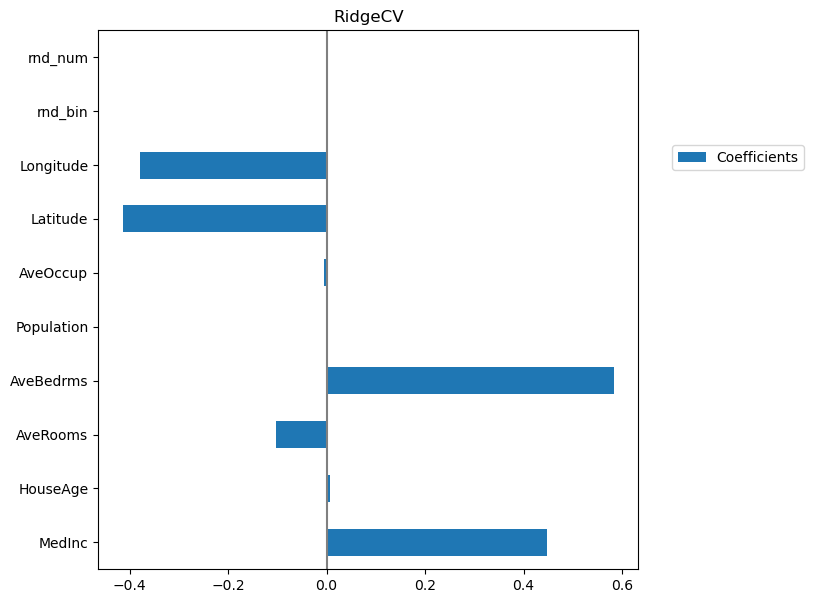

In [51]:
coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'],
   index=X_train.columns
)

coefs.plot(
   kind='barh',
   figsize=(9, 7)
)

plt.title('RidgeCV')
plt.axvline(
   x=0,
   color='.5'
)

plt.subplots_adjust(left=.3)
_ = plt.legend(
   bbox_to_anchor=(1.05, 0.8),
   loc="upper left"
)


**Sign of coefficients**

The coefficients of a linear model are a conditional association, i.e., They quantify the variation of the output (the price) when the **given feature is varied, keeping all other features constant.** 

**We should not interpret them as a marginal association, characterizing the link between the two quantities and ignoring the rest.**

The coefficient associated with `AveRooms` is negative because the number of rooms is strongly correlated with the number of bedrooms, `AveBedrms`. 



**Scale of coefficients**

The `AveBedrms` have the higher coefficient. However, we can't compare the magnitude of these coefficients directly since they are not scaled. 

Indeed, `Population` is an integer which can be thousands, while `AveBedrms` is around four and `Latitude` is in degree.

The population coefficient is expressed in 100 k$ /habitant while the `AveBedrms` is expressed in  100 k$ / number of bedrooms and the Latitude coefficient in 100 k$ / degree.


We will see that changing population by one does not change the outcome, while as we go south (latitude increase), the price becomes cheaper. 

Also, adding a bedroom (keeping all other features constant) shall raise the price of the house by 80 k$.

So looking at the coefficient plot to gauge feature importance can be misleading as some variation on a small scale. In contrast, others vary a lot more, which becomes evident if we compare the standard deviations of our different features.

So before any interpretation, we need to scale each column (removing the mean and scaling the variance to 1).

**Scaling of input data is essential when comparing the Scale of coefficients**

<br>

Once we have scaled the coefficients, we can safely compare them.

We will observe that the median income feature, longitude, and latitude are the three variables that most influence the model.

**The plot will tell us about dependencies between a specific feature and the target when all other features remain constant, i.e., conditional dependencies.** 

*An increase in the `HouseAge` will increase the price when all other features remain constant.* 

*On the contrary, an increase in the average rooms will induce a decrease in the price when all other features remain constant.*


(0.0, 100.0)

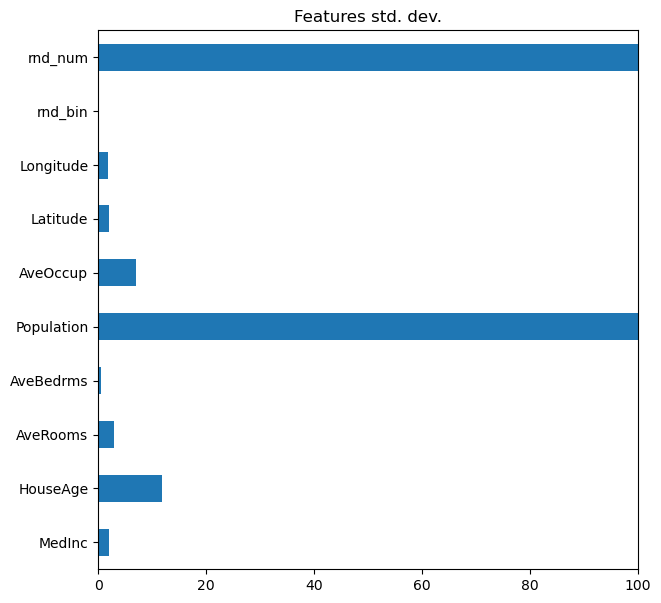

In [52]:
X_train.std(axis=0).plot(
    kind='barh',
    figsize=(9, 7)
)

plt.title('Features std. dev.')
plt.subplots_adjust(left=.3)
plt.xlim((0, 100))

In [53]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(
    StandardScaler(),
    RidgeCV()
)

model.fit(
    X_train,
    y_train
)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.6048511948222108
model score on testing data: 0.586338127456487


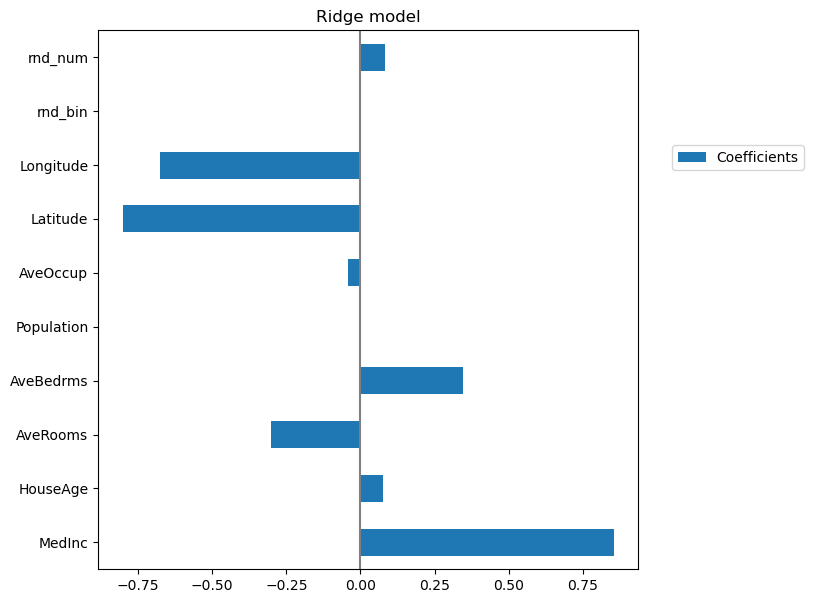

In [54]:
coefs = pd.DataFrame(
   model[1].coef_,
   columns=['Coefficients'],
   index=X_train.columns
)

coefs.plot(
   kind='barh',
   figsize=(9, 7)
)

plt.title('Ridge model')

plt.axvline(
   x=0,
   color='.5'
)

plt.subplots_adjust(left=.3)

_ = plt.legend(
   bbox_to_anchor=(1.05, 0.8),
   loc="upper left"
)

**Checking the variability of the coefficients**

We can check the coefficient variability through cross-validation: **it is a form of data perturbation**.

*If coefficients vary significantly when we change the input dataset, their robustness is not guaranteed, and they should probably be interpreted with caution.*

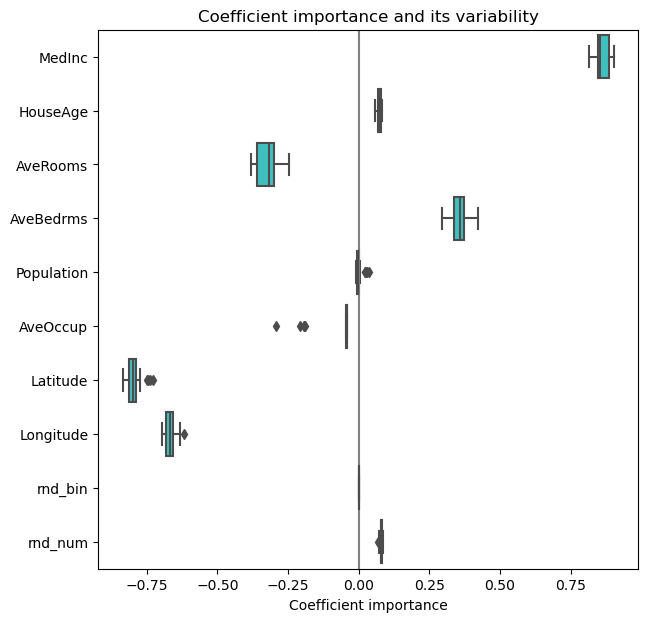

In [55]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
   model,
   X_with_rnd_feat,
   y,
   cv=RepeatedKFold(
      n_splits=5,
      n_repeats=5
   ),
   return_estimator=True,
   n_jobs=2
)

coefs = pd.DataFrame(
   [
      model[1].coef_ 
      for model in cv_model['estimator']
   ],
   columns=X_with_rnd_feat.columns
)

plt.figure(figsize=(9, 7))

sns.boxplot(
   data=coefs,
   orient='h',
   color='cyan',
   saturation=0.5
)

plt.axvline(
   x=0,
   color='.5'
)

plt.xlabel('Coefficient importance')

plt.title('Coefficient importance and its variability')

plt.subplots_adjust(left=.3)


**Linear models with sparse coefficients (Lasso)**

It is vital to remember that the associations extracted depend on the model. 
To illustrate this point, we consider a Lasso model that performs feature selection with an L1 penalty. 

We will fit the Lasso model with important regularization parameters `alpha`. We will observe that the model score is slightly lower because of the strong regularization. 

However, regularization has zeroed out three coefficients, selecting a small number of variables to make its prediction.

We will observe that the model has selected one out of the two correlated features, `AveRooms` and `AveBedrms`. 

Note that this choice is partly arbitrary: 

**choosing one does not mean that the other is not important for prediction.**

*Avoid over-interpreting models, as they are imperfect.*

We will then look at the variability of the coefficients:

We will see that both the coefficients associated with `AveRooms` and `AveBedrms` have a substantial variability and can be non-zero. 

Given that they are strongly correlated, the model can pick one or the other to predict well. 

Again, **This choice is a bit arbitrary and must not be over-interpreted.**


In [56]:
from sklearn.linear_model import Lasso

model = make_pipeline(
    StandardScaler(),
    Lasso(alpha=.015)
)

model.fit(
    X_train,
    y_train
)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.5933235371761756
model score on testing data: 0.5673786563118284


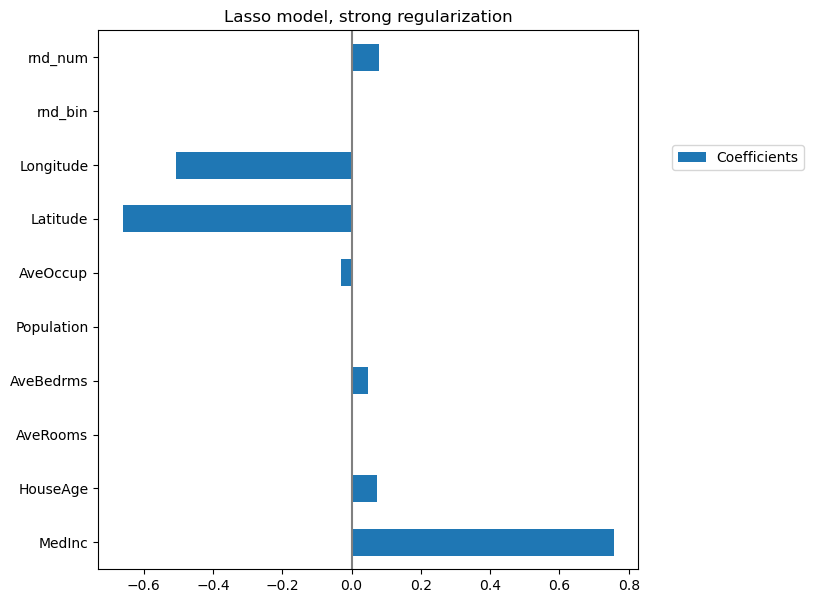

In [57]:
coefs = pd.DataFrame(
   model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(
   kind='barh',
   figsize=(9, 7)
)

plt.title('Lasso model, strong regularization')

plt.axvline(
   x=0,
   color='.5'
)

plt.subplots_adjust(left=.3)

_ = plt.legend(
   bbox_to_anchor=(1.05, 0.8),
   loc="upper left"
)

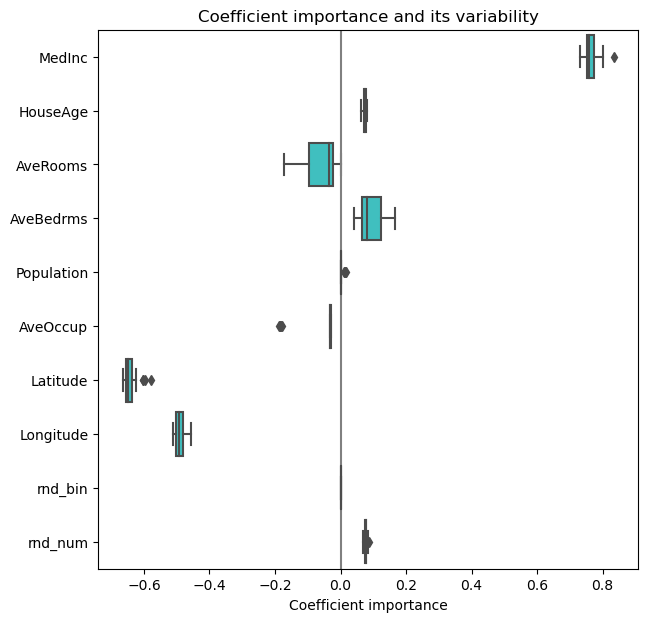

In [58]:
# variability of the coefficients

cv_model = cross_validate(
   model,
   X_with_rnd_feat,
   y,
   cv=RepeatedKFold(
      n_splits=5,
      n_repeats=5
   ),
   return_estimator=True,
   n_jobs=2
)

coefs = pd.DataFrame(
    [
       model[1].coef_
       for model in cv_model['estimator']
    ],
   columns=X_with_rnd_feat.columns
)

plt.figure(figsize=(9, 7))

sns.boxplot(
    data=coefs,
    orient='h',
    color='cyan',
    saturation=0.5
)

plt.axvline(x=0, color='.5')

plt.xlabel('Coefficient importance')

plt.title('Coefficient importance and its variability')

plt.subplots_adjust(left=.3)


**Lessons learned**

1. Coefficients must be scaled to the same unit of measure to retrieve feature importance or compare them.

2. Coefficients in multivariate linear models represent the dependency between a given feature and the target, conditional on the other features.

3. Correlated features might induce instabilities in the coefficients of linear models, and their effects cannot be well segregated.

4. Inspecting coefficients across the folds of a cross-validation loop gives an idea of their stability.

##### RandomForest and `feature_importances_`

Some feature importance methods are inherently built within the model on some algorithms, like the RandomForest. 

Now we investigate the built-in feature_importances_ attribute.


In the case of RandomForest, the importance of a feature is basically: 
**how much this feature is used in each tree of the forest.** 

*Formally, it is computed as the (normalized) total reduction of the criterion brought by that feature.*

When we plot `feature_importances_`, we will notice that the Median income remains the essential feature. 

*We also observe that `feature_importances_` has a small bias toward high cardinality features, such as the noisy feature `rnd_num`, which get predicted having .07 importance, more than HouseAge (which has low cardinality).*


In [59]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

model.fit(
    X_train,
    y_train
)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.9799159631987439
model score on testing data: 0.8465250974539443


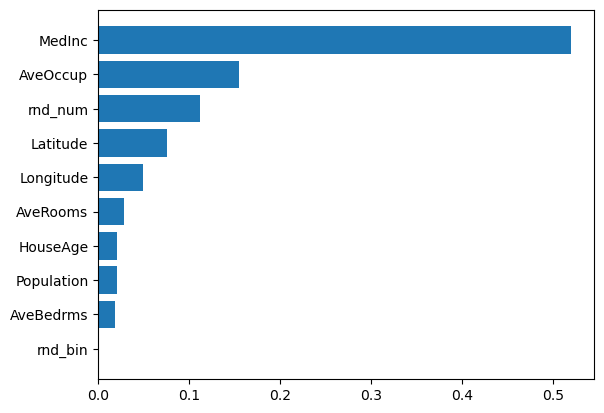

In [60]:
importances = model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()

ax.barh(
    range(len(importances)),
    importances[indices]
)

ax.set_yticks(range(len(importances)))

_ = ax.set_yticklabels(np.array(X_train.columns)[indices])



##### Feature importance by permutation

Now we introduce a new technique to evaluate the feature importance of any given fitted model. 

**It shuffles a feature and sees how the model changes its prediction. Thus, the change in prediction will correspond to the feature importance.This methodology can be used with any model and is not constrained to a particular class of models.**

We will use `RandomForestRegressor`, but other models can be used.

Once fitted, we will compute the importance of a given feature - the `MedInc` feature.

We will shuffle this specific feature, i.e., `MedInc`, keeping the other feature as is, and run our same model (already fitted) to predict the outcome. 

The decrease in the score shall indicate how the model had used this feature to predict the target. 

**The permutation feature importance is the decrease in a model score when a single feature value is randomly shuffled.**

*For instance, if a feature is crucial for the model, the outcome would be permuted, just like the feature; thus, the score would be close to zero.*

Afterward, the feature importance is the decrease in score. So, in that case, the feature importance would be close to the score.


On the contrary, the score shall remain the same if the model does not use the feature. Thus the feature importance will be close to 0.

<br>

We will plot the permuted features and see again that the feature `MedInc`, `Latitude`, and `Longitude` are significant for the model.

We note that our random variable `rnd_num` is now less important than `latitude`. 

Indeed, the feature importance built-in in RandomForest has a bias for continuous data, such as `AveOccup` and `rnd_num`. However, the model still uses these `rnd_num` features to compute the output. It is in line with the overfitting we had noticed between the train and test score.

<br>

Few important things

1. For correlated features, the permutation could give a nonrealistic sample (e.g., no of bedrooms higher than the number of rooms)

2. Whether you should use training or testing data to compute the feature importance is unclear.

3. Please observe that dropping a column and fitting a new model will not allow analyzing the feature importance for a specific model because we will fit a new model and not use the same old one.


In [61]:
# Any model could be used here, we pick RandomForestRegressor

model = RandomForestRegressor()
model.fit(
    X_train,
    y_train
)

# the model gives a good prediction, it has captured well the link between X and y. 
# Hence, it is reasonable to interpret what it has captured from the data.

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')


model score on training data: 0.9801798484727312
model score on testing data: 0.8465521641723839


In [62]:
def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()

    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values
    )

    permuted_score = model.score(
        X_permuted,
        y
    )

    return permuted_score


def get_feature_importance(model, X, y, curr_feat):
    """ compare the score when curr_feat is permuted """

    baseline_score_train = model.score(X, y)
    permuted_score_train = get_score_after_permutation(
        model,
        X,
        y,
        curr_feat
    )

    # feature importance is the difference between the two scores
    feature_importance = baseline_score_train - permuted_score_train
    return feature_importance


In [63]:
curr_feat = 'MedInc'

feature_importance = get_feature_importance(
    model,
    X_train,
    y_train,
    curr_feat
)

print(
    f'feature importance of "{curr_feat}" on train set is '
    f'{feature_importance:.3}'
)

feature importance of "MedInc" on train set is 0.668


In [64]:
n_repeats = 10

list_feature_importance = []
for n_round in range(n_repeats):
    list_feature_importance.append(
        get_feature_importance(
            model,
            X_train,
            y_train,
            curr_feat
        )
    )

print(
    f'feature importance of "{curr_feat}" on train set is '
    f'{np.mean(list_feature_importance):.3} '
    f'+/- {np.std(list_feature_importance):.3}'
)

feature importance of "MedInc" on train set is 0.677 +/- 0.0162


In [65]:
def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(
                    model,
                    X,
                    y,
                    curr_feat
                )
            )

        importances.append(list_feature_importance)

    return {
        'importances_mean': np.mean(importances, axis=1),
        'importances_std': np.std(importances, axis=1),
        'importances': importances
    }

# This function could directly be access from sklearn
# from sklearn.inspection import permutation_importance

In [66]:
def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots()

    indices = perm_importance_result['importances_mean'].argsort()
    
    plt.barh(
        range(len(indices)),
        perm_importance_result['importances_mean'][indices],
        xerr=perm_importance_result['importances_std'][indices]
    )

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])

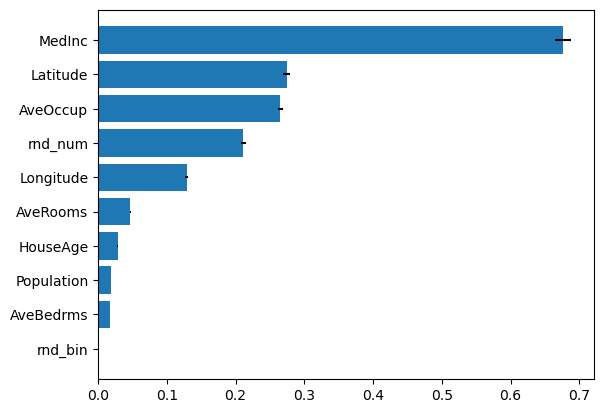

In [67]:
perm_importance_result_train = permutation_importance(
    model,
    X_train,
    y_train,
    n_repeats=10
)

plot_feature_importances(
    perm_importance_result_train,
    X_train.columns
)

##### QUIZ 1

**1. With a same dataset, feature importance might differs if:**

a) we use two different models

b) we use two different train/test split with a same model

c) we use a same model with a different set of hyper-parameters

d) we use a same model with the same set of hyper-parameters but a different random_state

<br>

**2. In linear model, the feature importance:**

a) might be infer from the coefficients

b) might be infer by importance_permutation

c) need a regularization to infer the importance

d) is a built-in attribute

<br>

**3. If two feature are the same (thus correlated)**

a) their feature importance will be the same

b) their feature importance will be divided by 2

c) only one will receive all the feature importance, the second one will be 0

d) it depends

<br>

**4. The feature importance provided by the scikit-learn random forest:**

a) has bias for categorical feature

b) has bias for continuous (high cardinality) feature

c) is independent from the train/test split

d) is independent from the hyper-parameters

<br>

**5. To evaluate the feature importance for a specific model, one could:**

a) drop a column and compare the score

b) shuffle a column and compare the score

c) put all column to 0 and compare the score

d) change a column value to random number and compare the score

<br>

#### Feature Selection

In this section, we aim to introduce the main benefits of using feature selection.

**The principal advantage of selecting features within a machine learning pipeline is to reduce the time to train this pipeline and its time to predict.**

First, we generate a synthetic dataset to control the number of features that will be informative, redundant, repeated, and random.

We choose to create a dataset with two informative features among a hundred. 

*To simplify our example, we do not include either redundant or repeated features.*


We will create two machine learning pipelines. 

1. The former will be a random forest that will use all available features. 

2. The latter will also be a random forest, but we will add a feature selection step to train this classifier. 

    The feature selection is based on a univariate test (ANOVA F-value) between each feature and the target we want to predict, and we will select features with the two most significant scores.


We will measure the average time spent to train each pipeline and predict it. Besides, we will compute the testing score of the model. We will collect these results via cross-validation.

<br>

We will start with the random forest without feature selection and store the results in a dataframe. Then we will repeat the process for the pipeline incorporating the feature selection. We will also merge the results from the two pipelines into a single pandas dataframe to do a comparative analysis of the results.

We will first analyze the train and score time for each pipeline. And we observe that for both training and scoring elapsed time: selecting the most informative features speeds up our pipeline.

*Of course, such speed-up will be beneficial only if the generalization performance in metrics remains the same*, and thus we next check the testing score.

We will observe that the model's generalization performance selecting a subset of features decreases compared with the model using all available features. 

Since we generated this dataset, we can infer that the decrease is because of the selection. The feature selection algorithm did not choose the two informative features.

We can investigate which features have been selected during the cross-validation, and we will do so by printing the indices of the two selected features.

**One feature is always selected, while the other varies depending on the cross-validation fold. And we know we have two features of importance, so this means that selection didn't pick both the relevant features.**

<br>

We could choose another metric to perform the test or select more features if we want to keep our score with a similar generalization performance. For instance, we could select the number of features based on a specific percentile of the highest scores. Besides, we should remember that we simplify our problem by having informative features and not redundant and repetitive features. 
**Correlation between features makes the problem of feature selection even harder.**

Therefore, we could develop a much more complicated procedure that could tune (via cross-validation) the number of selected features and change how the feature is selected (e.g., using a machine-learning model). 

However, going towards these solutions alienates the feature selection's primary purpose to get a significant train/test speed-up. 

Also, if the primary goal was to get a more performant model, performant models exclude non-informative features natively.

In [68]:
from sklearn.datasets import make_classification

data, target = make_classification(
    n_samples=5000,
    n_features=100,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    random_state=42,
)

In [69]:
from sklearn.ensemble import RandomForestClassifier

model_without_selection = RandomForestClassifier(n_jobs=2)


In [70]:
# Select features according to the k highest scores
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline


model_with_selection = make_pipeline(
    SelectKBest(
        score_func=f_classif,
        k=2
    ),
    RandomForestClassifier(n_jobs=2),
)

In [71]:
import pandas as pd
from sklearn.model_selection import cross_validate

cv_results_without_selection = cross_validate(
    model_without_selection,
    data,
    target
)

cv_results_without_selection = pd.DataFrame(cv_results_without_selection)

In [72]:
cv_results_with_selection = cross_validate(
    model_with_selection,
    data,
    target,
    return_estimator=True
)

cv_results_with_selection = pd.DataFrame(cv_results_with_selection)

In [73]:
cv_results = pd.concat(
    [cv_results_without_selection, cv_results_with_selection],
    axis=1,
    keys=["Without feature selection", "With feature selection"],
)

# swap the level of the multi-index of the columns
cv_results = cv_results.swaplevel(axis="columns")

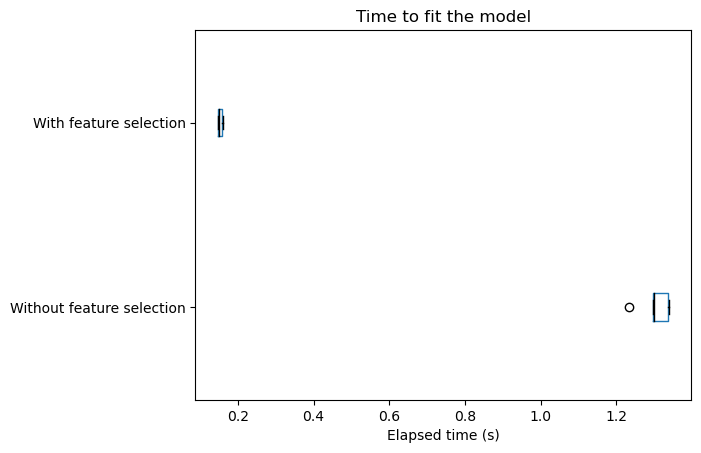

In [74]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
cv_results["fit_time"].plot.box(color=color, vert=False)
plt.xlabel("Elapsed time (s)")
_ = plt.title("Time to fit the model")

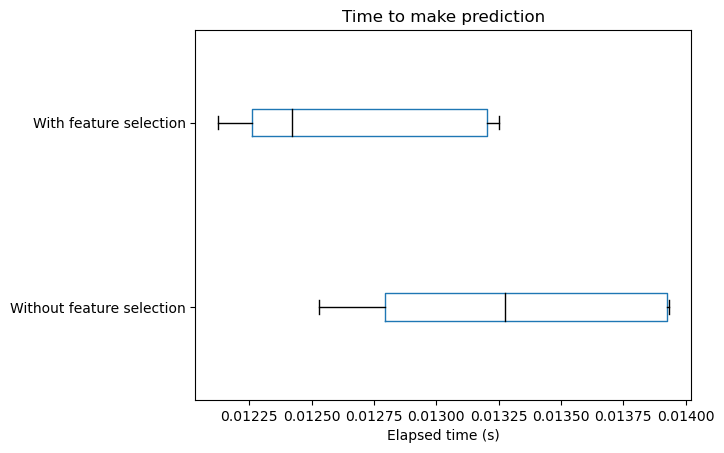

In [75]:
cv_results["score_time"].plot.box(
    color=color,
    vert=False
)

plt.xlabel("Elapsed time (s)")
_ = plt.title("Time to make prediction")

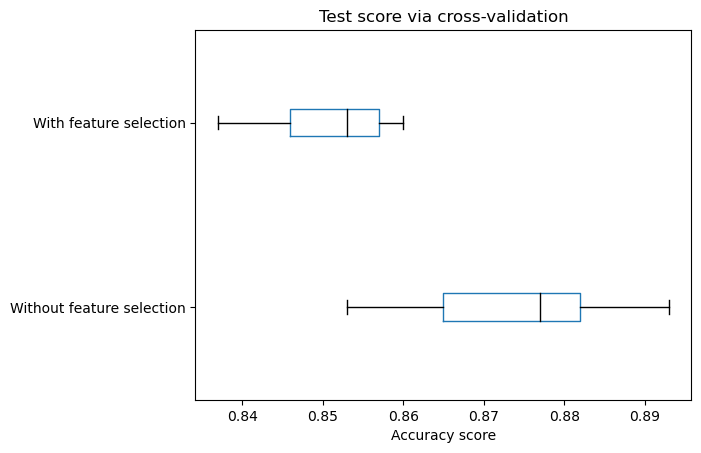

In [76]:
cv_results["test_score"].plot.box(
    color=color,
    vert=False
)

plt.xlabel("Accuracy score")
_ = plt.title("Test score via cross-validation")

In [77]:
import numpy as np

for idx, pipeline in enumerate(cv_results_with_selection["estimator"]):
    print(
        f"Fold #{idx} - features selected are: "
        f"{np.argsort(pipeline[0].scores_)[-2:]}"
    )

Fold #0 - features selected are: [80 26]
Fold #1 - features selected are: [85 26]
Fold #2 - features selected are: [42 26]
Fold #3 - features selected are: [42 26]
Fold #4 - features selected are: [14 26]


##### Caveats to consider

The section aims to highlight the caveats when using feature selection. 

*You have to be extremely careful regarding the data on which you will compute the statistic that helps your feature selection algorithm decide which feature to select.*

We will program the wrong way of making feature selection for the demonstration to gain insights.

First, we will create a completely random dataset using NumPy consisting of 100 samples and 100,000 features, with binary target 0 or 1.

This type of dimensionality is typical in bioinformatics when dealing with RNA-seq. However, we will use completely randomized features such that we don’t have a link between the data and the target. Thus, the generalization performance of any machine-learning model should not perform better than the chance level.

We will pick the logistic regression model and use cross-validation to check the score of such a model. Unsurprisingly, the logistic regression model will perform as bad as pure chance when we provide the whole dataset.

<br>

1. Now, we will use the wrong pattern to select the feature. 

    We will choose ten features with the highest ANOVA F-score computed on the full dataset. 

    Subsequently, we subsample the dataset data by selecting the features’ subset and, finally, train and test a logistic regression model.

    Surprisingly, the logistic regression succeeded in having a fantastic accuracy using data that did not link with the target in the first place. 

    *We, therefore, know that these results are not legit.*

    *The reasons for obtaining these results are twofold: the pool of available features is large compared to the number of samples. Finding a subset of features will link the data, and the target is possible. By not splitting the data, we leak knowledge from the entire dataset and could use this knowledge while evaluating our model.*

<br>

2. Now, we will use the right way to select the feature. First, we will split the dataset into a training and testing set. Then, we fit the feature selector on the training set and transform the training and testing sets before you train and test the logistic regression.


    We will see that selecting features only on the training set will not help when testing our model, and thus not surprising that our model will get the expected chance level results.

    **Therefore, as with hyperparameters optimization or model selection, tuning the feature space should be done solely on the training set, leaving some of the data out.**

<br>

However, how we implement the latter is not a perfect approach to take. 

For instance, if we were asked to perform cross-validation, the manual fit/transform of the datasets would make our life hard. 

Indeed, the solution here is to use a scikit-learn pipeline in which the feature selection will be a pre-processing stage before training the model.

Thus finally, we create a pipeline with the feature selector and the logistic regression. 

Then, use cross-validation to estimate the uncertainty of your model generalization performance.

<br>  

We see that using a scikit-learn pipeline removes a lot of boilerplate code and helps avoid mistakes when calling fit and transform on the different data sets.

  

In [78]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

"""
Using the function np.random.randn, generate a matrix data containing 100 samples and 100,000 features. 
Then, using the function np.random.randint, generate a vector target with 100 samples containing either 0 or 1.
"""
rng = np.random.RandomState(42)
data, target = rng.randn(100, 100000), rng.randint(0, 2, size=100)


"""
Now, create a logistic regression model and use cross-validation to check the score of such a model. 
It will allow use to confirm that our model cannot predict anything meaningful from random data.
"""
model = LogisticRegression()
test_score = cross_val_score(
    model,
    data,
    target,
    n_jobs=2
)

print(f"The mean accuracy is: {test_score.mean():.3f}")

The mean accuracy is: 0.550


In [79]:
from sklearn.feature_selection import SelectKBest, f_classif

feature_selector = SelectKBest(
    score_func=f_classif,
    k=10
)

data_subset = feature_selector.fit_transform(
    data,
    target
)

test_score = cross_val_score(
    model,
    data_subset,
    target
)

print(f"The mean accuracy is: {test_score.mean():.3f}")

The mean accuracy is: 0.940


In [80]:
from sklearn.model_selection import train_test_split


data_train, data_test, target_train, target_test = train_test_split(
    data,
    target,
    random_state=42
)

feature_selector.fit(
    data_train,
    target_train
)

data_train_subset = feature_selector.transform(
    data_train
)

data_test_subset = feature_selector.transform(
    data_test
)

model.fit(
    data_train_subset,
    target_train
)

test_score = model.score(
    data_test_subset,
    target_test
)

print(f"The mean accuracy is: {test_score:.3f}")

The mean accuracy is: 0.360


In [81]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

feature_selector = SelectKBest(
    score_func=f_classif,
    k=10
)

model = make_pipeline(
    feature_selector,
    LogisticRegression()
)

test_score = cross_val_score(model, data, target)
print(f"The mean accuracy is: {test_score.mean():.3f}")

The mean accuracy is: 0.460



##### Limitation of selecting features using a model

In this section, we want to show a limitation when using a machine-learning model to make a selection.

First, we build a model which will not make any feature selection.

We will evaluate this model by k-fold cross-validation and store the results in a pandas dataframe. Indeed, one can inspect this model and find relative feature importances. 

For instance, the parameters `coef_` for the linear models or `feature_importances_` for the tree-based models carry such information. 

Therefore, this method works as far as the relative feature importance given by the model is sufficient to select the noteworthy feature.

We will generate a dataset that contains a large number of random features. Then, we will build another model that includes a feature selection step based on a random forest and evaluate it with cross-validation.

We can compare the testing score of the two models by combining results in a single dataframe.

Finally, we can check the testing score of each model.

The model that selected a feature subset is less performant than a random forest fitted on the full dataset.

<br>

**The decision tree’s relative feature importance will overestimate the importance of random features when the decision tree overfits the training set.**

*Therefore, it is good to remember that feature selection relies on procedures making some assumptions, which can be perfectible.*

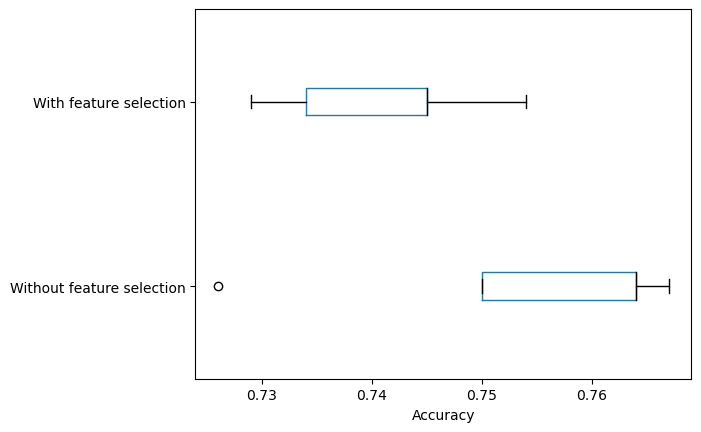

In [82]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

data, target = make_classification(
    n_samples=5000,
    n_features=100,
    n_informative=2,
    n_redundant=5,
    n_repeated=5,
    class_sep=0.3,
    random_state=42,
)

model_without_selection = RandomForestClassifier()

cv_results_without_selection = cross_validate(
    model_without_selection,
    data, target,
    cv=5
)

cv_results_without_selection = pd.DataFrame(
    cv_results_without_selection
)


feature_selector = SelectFromModel(
    RandomForestClassifier()
)

model_with_selection = make_pipeline(
    feature_selector,
    RandomForestClassifier()
)

cv_results_with_selection = cross_validate(
    model_with_selection,
    data,
    target,
    cv=5
)

cv_results_with_selection = pd.DataFrame(
    cv_results_with_selection
)

cv_results = pd.concat(
    [cv_results_without_selection, cv_results_with_selection],
    axis=1,
    keys=["Without feature selection", "With feature selection"],
).swaplevel(axis="columns")


color = {
    "whiskers": "black",
    "medians": "black",
    "caps": "black"
}

cv_results["test_score"].plot.box(
    color=color,
    vert=False
)

plt.xlabel("Accuracy")

plt.show()

##### QUIZ 2

**1. What is the main advantage of using feature selection?**


a) speeding-up the training of an algorithm

b) fine tuning the model’s performance

c) remove noisy features

<br>


**2. When selecting feature, the decision should be made using:**

a) the entire dataset

b) the training set

c) the testing set

<br>


